# **Imports**

In [ ]:
!pip install -q split-folders

In [ ]:
import torch
import random
import shutil
import warnings
import numpy as np
import pandas as pd
import splitfolders
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.metrics import confusion_matrix, classification_report

warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Data Processing**

In [ ]:
try:
  shutil.rmtree('/content/data')
  shutil.rmtree('/content/dataset')
  shutil.rm('/content/model.pth')
except:
  pass

In [ ]:
!unzip /content/drive/MyDrive/Colab\ Notebooks/dataset.zip

In [ ]:
splitfolders.ratio('/content/data',
                   output ='/content/dataset',
                   seed = 42,
                   ratio = (.7, .2, .1),
                   group_prefix = None,
                   move = False)

Copying files: 4188 files [00:00, 5080.07 files/s]


In [ ]:
train_transformations = transforms.Compose([transforms.Resize( size = (256, 256)),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.RandomVerticalFlip(),
                                            transforms.GaussianBlur(kernel_size = (3, 7), sigma = (0.1, 2)),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                                 std = [0.229, 0.224, 0.225])])

In [ ]:
valid_test_transformations = transforms.Compose([transforms.Resize(size = (256, 256)),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                                 std = [0.229, 0.224, 0.225])])

In [ ]:
train_data = datasets.ImageFolder(root = '/content/dataset/train',
                                  transform = train_transformations)

In [ ]:
valid_data = datasets.ImageFolder(root = '/content/dataset/val',
                                  transform = valid_test_transformations)

In [ ]:
test_data = datasets.ImageFolder(root = '/content/dataset/test',
                                  transform = valid_test_transformations)

In [ ]:
print(f'Dataset Labels: {train_data.class_to_idx}')

Dataset Labels: {'Blight': 0, 'Common_Rust': 1, 'Gray_Leaf_Spot': 2, 'Healthy': 3}


In [ ]:
for name, dataset in zip(['Train', 'Valid', 'Test'], [train_data, valid_data, test_data]):
  images_per_class = pd.Series(dataset.targets).value_counts()
  print(f'{name} Dataset Length: {len(dataset)}')
  print(images_per_class, '\n')

Train Dataset Length: 2930
1    914
3    813
0    802
2    401
Name: count, dtype: int64 

Valid Dataset Length: 836
1    261
3    232
0    229
2    114
Name: count, dtype: int64 

Test Dataset Length: 422
1    131
3    117
0    115
2     59
Name: count, dtype: int64 



# **Showing Images**

In [ ]:
labels_for_viz = {v: k for k, v in valid_data.class_to_idx.items()}

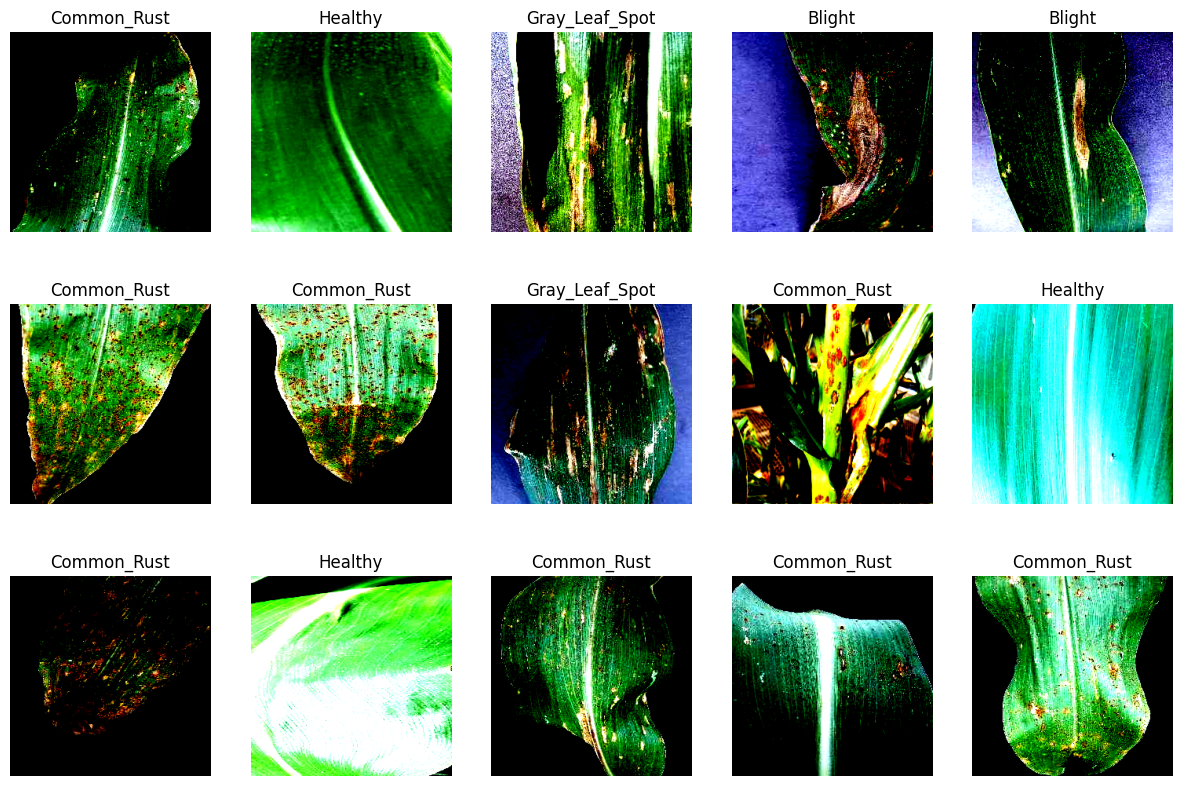

In [ ]:
fig, ax = plt.subplots(3, 5, figsize = (15, 10))
ax = ax.flatten()
for i in range(15):
  sample = random.randint(0, len(valid_data))
  ax[i].imshow(valid_data[sample][0].permute(1, 2, 0))
  ax[i].title.set_text(labels_for_viz[valid_data[sample][1]])

# **Data Loaders**

In [ ]:
train_loader = DataLoader(dataset = train_data,
                          batch_size = 32,
                          num_workers = 2,
                          shuffle = True)

In [ ]:
valid_loader = DataLoader(dataset = valid_data,
                          batch_size = 32,
                          num_workers = 2,
                          shuffle = True)

In [ ]:
test_loader = DataLoader(dataset = test_data,
                         batch_size = 32,
                         num_workers = 2,
                         shuffle = False)

# **Building Model**

In [ ]:
class ConvNeuralNetwork(nn.Module):
  def __init__(self):
    super(ConvNeuralNetwork, self).__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = 131072, out_features = 32),
        nn.ReLU(),
        nn.Linear(in_features = 32, out_features = 16),
        nn.ReLU(),
        nn.Linear(in_features = 16, out_features = 4)
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.fc(x)
    return x

In [ ]:
model = ConvNeuralNetwork()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

# **Training Model**

In [ ]:
learning_rate = 10e-3
epochs = 15

loss_fn = nn.CrossEntropyLoss()

optimizer - torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
def eval_model(model, dataset):
  running_val_loss = 0.0
  running_val_accuracy = 0.0
  val_total = 0
  model.eval()
  with torch.no_grad():
    for data in dataset:
      images, labels = data[0].to(device), data[1].to(device)

      predictions = model(images)

      val_loss = loss_fn(predictions, labels)

      _, predictions = torch.max(predictions, 1)

      running_val_loss += val_loss.item()

      val_total += labels.size(0)

      running_val_accuracy += (predictions == labels).sum().item()
  val_loss_value = running_val_loss / len(dataset)
  val_accuracy = (100 * running_val_accuracy) / val_total

  return val_loss_value, val_accuracy


In [ ]:
def train_model(model, loss_fn, optimizer, epochs, train_dataset, val_dataset):
  best_val_accuracy = 0.0
  train_loss_history = []
  val_loss_history = []
  train_accuracy_history = []
  val_accuracy_history = []

  for epoch in range(epochs):
    running_train_loss = 0.0
    running_train_accuracy = 0.0
    train_total = 0

    model.train()

    for data in train_dataset:
      images, labels = data[0].to(device), data[1].to(device)

      optimizer.zero_grad()

      predictions = model(images)

      train_loss = loss_fn(predictions, labels)

      _, train_predictions = torch.max(predictions, 1)

      running_train_accuracy += (train_predictions == labels).sum().item()

      train_total += labels.size(0)

      train_loss.backward()

      optimizer.step()

      running_train_loss += train_loss.item()

    train_loss_value = running_train_loss / len(train_dataset)
    train_loss_history.append(train_loss_value)
    train_accuracy = (100 * running_train_accuracy) / train_total
    train_accuracy_history.append(train_accuracy)

    val_loss_value, val_accuracy = eval_model(model, val_dataset)

    val_loss_history.append(val_loss_value)
    val_accuracy_history.append(val_accuracy)

    if val_accuracy > best_val_accuracy:
      torch.save(model.state_dict(), 'model.pth')
      best_val_accuracy = val_accuracy

    print(f'Epoch: {epoch + 1} \n Train Loss: {train_loss_value} \n Train Accuracy: {train_accuracy}% \n Val Loss: {val_loss_value} \n Val Accuracy: {val_accuracy}%')

    return train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history

In [ ]:
%%time
train_loss_history, val_loss_history, train_accuracy_history, val_accuracy_history = train_model(model, loss_fn, optimizer, epochs, train_loader, valid_loader)

# **Testing Model**

In [ ]:
def test_model(model, dataset, load = False, path = None):
  if load:
    model.load_state_dict(torch.load(path))

  model.eval()

  running_accuracy = 0

  total = 0

  all_predictions = []

  with torch.no_grad():
    for data in dataset:
      images, labels = data[0].to(device), data[1].to(device)

      labels = labels.to(torch.float32)

      predictions = model(images)

      _, predictions = torch.max(predictions, 1)

      total += labels.size(0)

      running_accuracy += (predictions == labels).sum().item()

      all_predictions.extend(predictions.cpu().numpy())

      _, predictions = torch.max(predictions, 1)

      total += labels.size(0)

      running_accuracy += (predictions == labels).sum().item()

      accuracy = 100 + running_accuracy / total

      all_predictions.append(list(predictions.cpu().numpy()))

    print(f'Accuracy: {accuracy}')

  return np.hstack(all_predictions)

In [ ]:
result = test_model(model, test_loader, load = True, path = '/content/model.pth')

In [ ]:
fig, ax = plt.subplots(2, 1, figsize = (12, 10))
ax = ax.flatten()

ax[0].plot(train_accuracy_history, label = 'Train Accuracy')
ax[0].plot(val_accuracy_history, label = 'Val Accuracy')
ax[0].legend()
ax[0].set_title('Accuracy')

ax[1].plot(train_loss_history, label = 'Train Loss')
ax[1].plot(val_loss_history, label = 'Val Loss')
ax[1].legend()
ax[1].set_title('Loss')

plt.show()

In [ ]:
print(classification_report(test_data.targets, result, target_names = ['0', '1', '2', '3']))

In [ ]:
plt.figure(figsize = (10, 10))
sns.heatmap(confusion_matrix(test_data.targets, result), annot = True, fmt = 'd')
plt.title('Confusion Matrix', size = 15)
plt.show()